In [1]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns

%matplotlib inline

# К сожалению, я все таки сделал домашнее задание с Титаником
**Домашнее задание скачал 20 октября и мне показалось, что уже и на лекции прозвучало, что можно выполнять и  
на сайте было объявлено, что домашнее задание правильное. Возможно мне следовало быть внимательнее или обновить кеш сайта.  
Так или иначе о том, что домашка сменилась я узнал только 24 октября, когда выполнил почти всю работу.  
Убедительно прошу, принять к оценке работу с Титаником, т.к. на носу диплом и лаба и на основной работе тоже дела.  
Если все же следует переделать работу по новым данным прошу продлить мне срок сдачи.   
С уважением, Максим**

In [46]:
import io
import requests
data=pd.read_csv("data/train.csv") 
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


PassengerId — идентификатор пассажира  
Survival — поле в котором указано спасся человек (1) или нет (0)  
Pclass — класс каюты:  
1 - высокий  
2 - средний  
3 - низкий  
Name — имя пассажира  
Sex — пол пассажира  
Age — возраст  
SibSp — содержит информацию о количестве родственников 2-го порядка (муж, жена, братья, сетры)  
Parch — содержит информацию о количестве родственников на борту 1-го порядка (мать, отец, дети)  
Ticket — номер билета  
Fare — цена билета  
Cabin — каюта  
Embarked — порт посадки:  
C — Cherbourg  
Q — Queenstown  
S — Southampton  

Информацию по датасету взял с https://habr.com/ru/company/mlclass/blog/270973/

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Ну, проблемы очевидны Cabin, Age. Каюты сразу решаем отбросить.

Хотя бы визуально прикинем , соотношение погибших - выживших по разным признакам

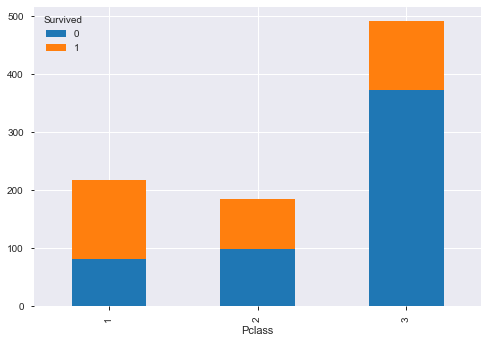

In [48]:
data.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)

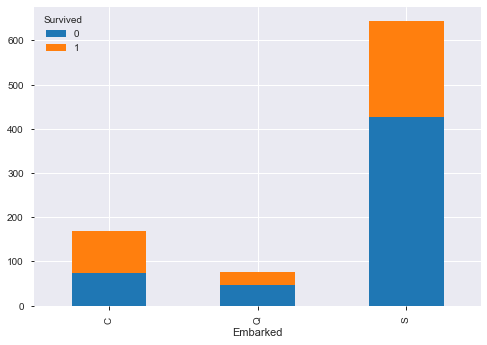

In [49]:
data.pivot_table('PassengerId', 'Embarked', 'Survived', 'count').plot(kind='bar', stacked=True)

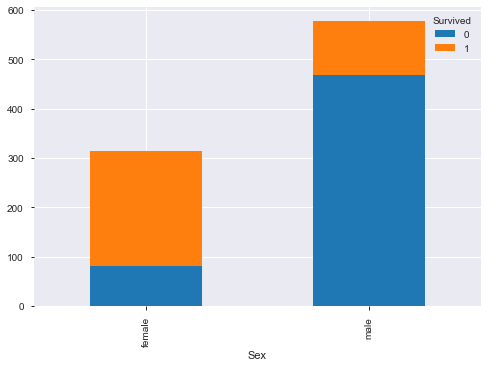

In [50]:
data.pivot_table('PassengerId', 'Sex', 'Survived', 'count').plot(kind='bar', stacked=True)

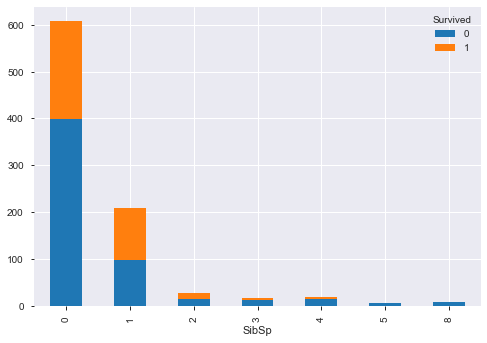

In [51]:
data.pivot_table('PassengerId', 'SibSp', 'Survived', 'count').plot(kind='bar', stacked=True)

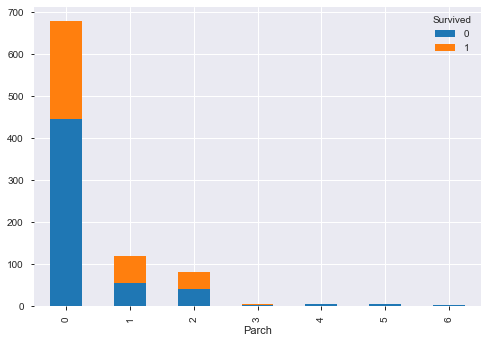

In [52]:
data.pivot_table('PassengerId', 'Parch', 'Survived', 'count').plot(kind='bar', stacked=True)

SibSp, Parch имеют интересную закономерность, люди с большим числом родственников не выжили.  
Однако, мне кажется, что статистически этих людей слишком мало, думаю в дальнейшем мы не будем рассматривать  
эти признаки. Порт посадки скорее всего тоже не важен, проверим это позже посмотрев его корреляцию с классами пассажиров

Теперь проработаем с именами

In [53]:
data['Status'] = ' '
ind = 0 
total = data['Name'].count()
print(total)
while ind < total:
    Name = data.loc[ind, 'Name']
    data.loc[ind, 'Status'] = Name.split(' ')[1]
    ind += 1
data.head()    

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Status
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


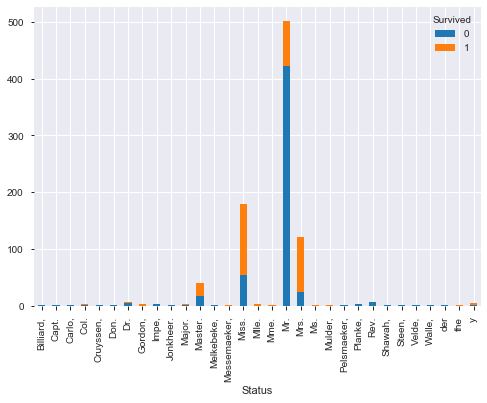

In [54]:
data.pivot_table('PassengerId', 'Status', 'Survived', 'count').plot(kind='bar', stacked=True)

In [55]:
data[(data['Status'] != 'Mr.') & (data['Status'] != 'Mrs.') & (data['Status'] != 'Miss.') & (data['Status'] != 'Master.')]['Name']

18     Vander Planke, Mrs. Julius (Emelia Maria Vande...
30                              Uruchurtu, Don. Manuel E
38                    Vander Planke, Miss. Augusta Maria
149                    Byles, Rev. Thomas Roussel Davids
150                           Bateman, Rev. Robert James
153                      van Billiard, Mr. Austin Blyler
170                            Van der hoef, Mr. Wyckoff
200                       Vande Walle, Mr. Nestor Cyriel
245                          Minahan, Dr. William Edward
249                        Carter, Rev. Ernest Courtenay
282                            de Pelsmaeker, Mr. Alfons
286                              de Mulder, Mr. Theodore
307    Penasco y Castellana, Mrs. Victor de Satode (M...
317                                 Moraweck, Dr. Ernest
333                      Vander Planke, Mr. Leo Edmondus
355                          Vanden Steen, Mr. Leo Peter
361                            del Carlo, Mr. Sebastiano
369                        Auba

Допущенная ошибка очевидна, исправим ее более корректным кодом

In [56]:
ind = 0 
total = data['Name'].count()
print(total)
while ind < total:
    Name = data.loc[ind, 'Name']
    Name = Name.split(',')[1]
    data.loc[ind, 'Status'] = Name.lstrip().split('.')[0]
    ind += 1
data.head()    

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Status
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


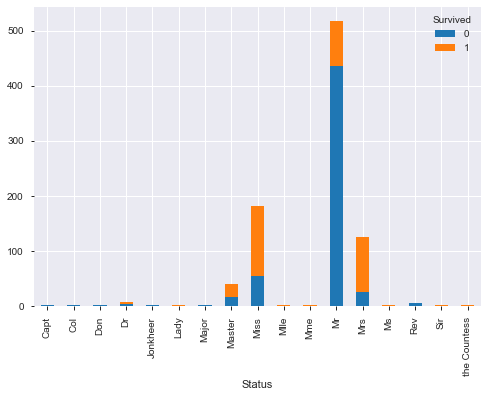

In [57]:
data.pivot_table('PassengerId', 'Status', 'Survived', 'count').plot(kind='bar', stacked=True)

In [58]:
data[(data['Status'] != 'Mr') & (data['Status'] != 'Mrs') & (data['Status'] != 'Miss') & (data['Status'] != 'Master')][['Name','Status']].count()

Name      27
Status    27
dtype: int64

In [60]:
data[(data['Status'] != 'Mr') & (data['Status'] != 'Mrs') & (data['Status'] != 'Miss') & (data['Status'] != 'Master')][['Name','Status']]

,Name,Status
30,"Uruchurtu, Don. Manuel E",Don
149,"Byles, Rev. Thomas Roussel Davids",Rev
150,"Bateman, Rev. Robert James",Rev
245,"Minahan, Dr. William Edward",Dr
249,"Carter, Rev. Ernest Courtenay",Rev
317,"Moraweck, Dr. Ernest",Dr
369,"Aubart, Mme. Leontine Pauline",Mme
398,"Pain, Dr. Alfred",Dr
443,"Reynaldo, Ms. Encarnacion",Ms
449,"Peuchen, Major. Arthur Godfrey",Major


Докторов, полковников, донов и преподобных отнесем в один класс,  
туда правда попало несколько женщин (даже одна контесса),  
но мучится не будем, на самом деле нам это не очень важно

In [61]:
data.loc[(data['Status'] != 'Mr') & (data['Status'] != 'Mrs') & (data['Status'] != 'Miss') & (data['Status'] != 'Master'), 'Status'] = 'Don'
data[data['Status'] == 'Don']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Status
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,Don
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S,Don
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,Don
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,Don
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0000,NaN,S,Don
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,Don
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C,Don
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Don
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S,Don
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,Don


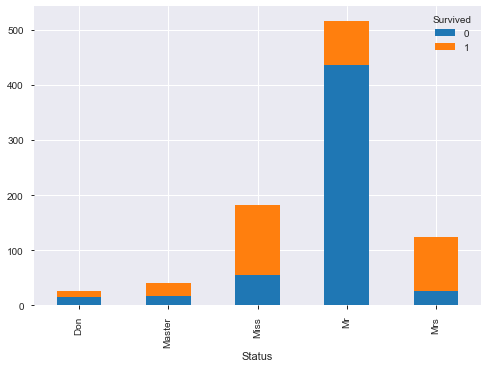

In [62]:
data.pivot_table('PassengerId', 'Status', 'Survived', 'count').plot(kind='bar', stacked=True)

Получили хороший график. Если эти данные носят исторический характер, то перед мистерами  
прошлого можно снять шляпу. Не думаю, что в повседневной жизни они были ангелами, но в критической  
ситуации спасали женщин и детей ценой собственной жизни (возможно это не так и я делаю распространенную статистическую ошибку, принимая статистическую зависимость  
                                                        за причинно-следственную связь).


Теперь мы можем пользуясь новым признаком, более корректно заполнить отсутствующие данные  
по возрасту, посчитав средний возраст по статусу

In [63]:
age_mean = data[data['Age'].notnull()].groupby('Status').mean()
Don = age_mean.loc['Don']['Age']
Mr = age_mean.loc['Mr']['Age']
Miss = age_mean.loc['Miss']['Age']
Mrs = age_mean.loc['Mrs']['Age']
Master = age_mean.loc['Master']['Age']
print(Don,Mr,Miss,Mrs,Master)

42.38461538461539 32.368090452261306 21.773972602739725 35.898148148148145 4.574166666666667


In [64]:
data.loc[(data['Status'] == 'Don') & data['Age'].isnull(), 'Age'] = Don
data.loc[(data['Status'] == 'Mr') & data['Age'].isnull(), 'Age'] = Mr
data.loc[(data['Status'] == 'Miss') & data['Age'].isnull(), 'Age'] = Miss
data.loc[(data['Status'] == 'Mrs') & data['Age'].isnull(), 'Age'] = Mrs
data.loc[(data['Status'] == 'Master') & data['Age'].isnull(), 'Age'] = Master
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Status         891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


Чтож проверим, что получилось

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024AC372E160>,
      dtype=object)

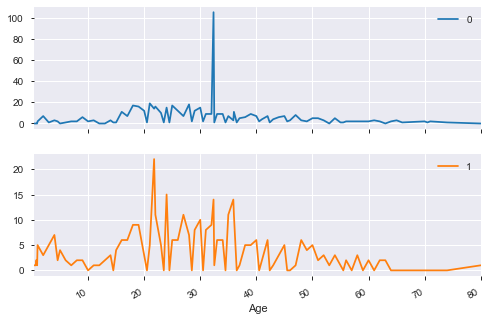

In [65]:
data.pivot_table('PassengerId', 'Age', 'Survived', 'count').plot(kind='line', subplots = True, stacked=True)

Опаньки. 'Шип' в районе среднего возраста мистеров внушает опасение, сможем ли мы корректно использовать признак по возрасту 

In [66]:
data[data['Status'] == 'Mr'].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,454.499033,0.156673,2.410058,32.368090,0.288201,0.152805,24.441560
std,253.715526,0.363844,0.810622,11.147429,0.821298,0.533615,44.378561
min,1.000000,0.000000,1.000000,11.000000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,25.000000,0.000000,0.000000,7.800000
50%,466.000000,0.000000,3.000000,32.368090,0.000000,0.000000,9.350000
75%,674.000000,0.000000,3.000000,35.000000,0.000000,0.000000,26.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,5.000000,512.329200


In [67]:
data[(data['Status'] == 'Mr') & (data['Age'] != Mr)].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,452.786432,0.168342,2.356784,32.368090,0.283920,0.178392,26.198219
std,254.382706,0.374640,0.817529,12.708793,0.616558,0.572973,47.570067
min,1.000000,0.000000,1.000000,11.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,23.000000,0.000000,0.000000,7.895800
50%,459.000000,0.000000,3.000000,30.000000,0.000000,0.000000,10.500000
75%,679.250000,0.000000,3.000000,39.000000,0.000000,0.000000,26.550000
max,891.000000,1.000000,3.000000,80.000000,5.000000,5.000000,512.329200


In [68]:
data[(data['Status'] == 'Mr') & (data['Age'] == Mr) & (data['Survived'] == 0)].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,105.000000,105.0,105.000000,1.050000e+02,105.000000,105.000000,105.000000
mean,463.800000,0.0,2.647619,3.236809e+01,0.323810,0.076190,17.744520
std,247.075526,0.0,0.720322,1.427901e-14,1.362233,0.384689,32.267803
min,6.000000,0.0,1.000000,3.236809e+01,0.000000,0.000000,0.000000
25%,271.000000,0.0,3.000000,3.236809e+01,0.000000,0.000000,7.725000
50%,482.000000,0.0,3.000000,3.236809e+01,0.000000,0.000000,7.895800
75%,649.000000,0.0,3.000000,3.236809e+01,0.000000,0.000000,15.500000
max,879.000000,0.0,3.000000,3.236809e+01,8.000000,2.000000,227.525000


In [69]:
data[(data['Status'] == 'Mr') & (data['Survived'] == 0)].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,436.000000,436.0,436.000000,436.000000,436.000000,436.000000,436.000000
mean,452.350917,0.0,2.488532,32.264104,0.300459,0.160550,21.218193
std,256.432937,0.0,0.756493,11.281616,0.873150,0.556594,33.085692
min,1.000000,0.0,1.000000,11.000000,0.000000,0.000000,0.000000
25%,221.500000,0.0,2.000000,24.000000,0.000000,0.000000,7.775000
50%,464.500000,0.0,3.000000,32.368090,0.000000,0.000000,8.662500
75%,675.250000,0.0,3.000000,35.000000,0.000000,0.000000,22.756250
max,891.000000,0.0,3.000000,74.000000,8.000000,5.000000,263.000000


Выводы по признаку 'Age'. Информация о возрасте 20% мистеров отсутствует. При этом 25% мистеров без данных о возрасте  
погибли. Я полагаю, что такой 'шип' не позволяет нам использовать данные по возрасту в модели. Погибшие могли быть  
старыми и немощными или наоборот слишком юными. В общем, 20% мужчин это слишком много для корректной статистики.  
'Age' исключаем

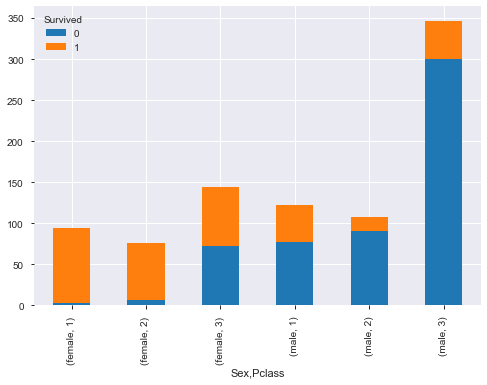

In [70]:
data.pivot_table('PassengerId', ('Sex', 'Pclass'), 'Survived', 'count').plot(kind='bar', stacked=True)

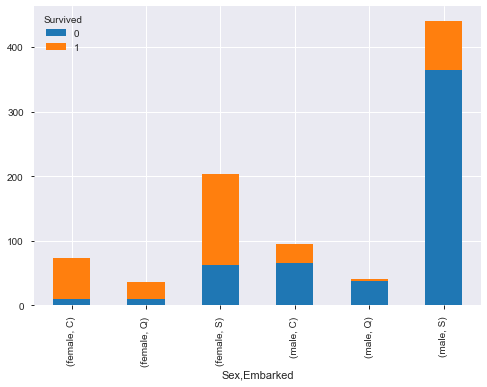

In [71]:
data.pivot_table('PassengerId', ('Sex', 'Embarked'), 'Survived', 'count').plot(kind='bar', stacked=True)

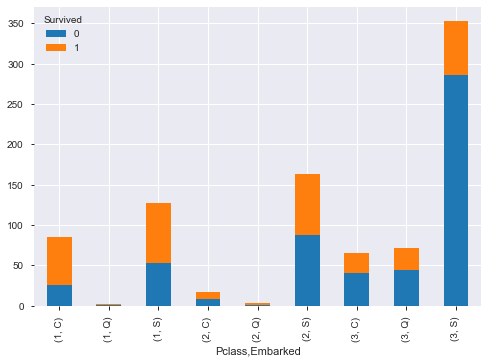

In [72]:
data.pivot_table('PassengerId', ('Pclass', 'Embarked'), 'Survived', 'count').plot(kind='bar', stacked=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024AC39C47B8>,
      dtype=object)

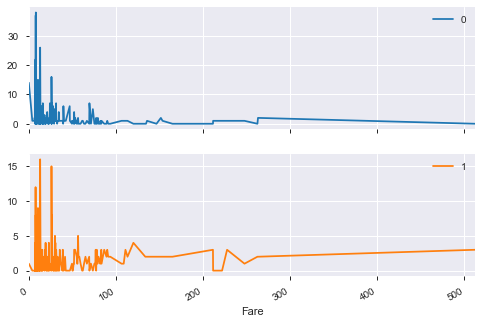

In [73]:
data.pivot_table('PassengerId', 'Fare', 'Survived', 'count').plot(kind='line', subplots = True, stacked=True)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Status         891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


Доводим данные до ума

In [75]:
data.drop(['Cabin', 'Ticket', 'PassengerId', 'Name', 'Age', 'SibSp', 'Parch'], axis='columns', inplace=True)
data.head(10)

,Survived,Pclass,Sex,Fare,Embarked,Status
0,0,3,male,7.2500,S,Mr
1,1,1,female,71.2833,C,Mrs
2,1,3,female,7.9250,S,Miss
3,1,1,female,53.1000,S,Mrs
4,0,3,male,8.0500,S,Mr
5,0,3,male,8.4583,Q,Mr
6,0,1,male,51.8625,S,Mr
7,0,3,male,21.0750,S,Master
8,1,3,female,11.1333,S,Mrs
9,1,2,female,30.0708,C,Mrs


Особенно повозимся с нашим новым признаком статус 'Status'. Есть мысль сделать их ранжированными, а не просто нумерованными. Мне кажется так лучше  
проявятся статистические зависимости, если они есть. Сделаем из них новый признак 'Statut', процент выживших в данном статусе

In [76]:
status_survived = data[['Sex','Status','Survived']].groupby(['Status','Survived']).count()
status_survived

Sex
Status Survived     
Don    0          15
       1          12
Master 0          17
       1          23
Miss   0          55
       1         127
Mr     0         436
       1          81
Mrs    0          26
       1          99

In [77]:
Don = round(status_survived.loc[('Don', 0)]['Sex']/(status_survived.loc[('Don', 1)]['Sex']+status_survived.loc[('Don', 0)]['Sex']),2)
Mr = round(status_survived.loc[('Mr', 0)]['Sex']/(status_survived.loc[('Mr', 1)]['Sex']+status_survived.loc[('Mr', 0)]['Sex']),2)
Miss = round(status_survived.loc[('Miss', 0)]['Sex']/(status_survived.loc[('Miss', 1)]['Sex']+status_survived.loc[('Miss', 0)]['Sex']),2)
Master = round(status_survived.loc[('Master', 0)]['Sex']/(status_survived.loc[('Master', 1)]['Sex']+status_survived.loc[('Master', 0)]['Sex']),2)
Mrs = round(status_survived.loc[('Mrs', 0)]['Sex']/(status_survived.loc[('Mrs', 1)]['Sex']+status_survived.loc[('Mrs', 0)]['Sex']),2)
print(Mr,Don,Master,Miss,Mrs)

0.84 0.56 0.42 0.3 0.21


In [78]:
data['Statut'] = 0
ind = 0 
total = data['Status'].count()
print(total)
while ind < total:
    Status = data.loc[ind, 'Status']
    if Status == 'Mr':
        data.loc[ind, 'Statut'] = Mr
    elif Status == 'Don':
        data.loc[ind, 'Statut'] = Don
    elif Status == 'Master':
        data.loc[ind, 'Statut'] = Master
    elif Status == 'Miss':
        data.loc[ind, 'Statut'] = Miss
    elif Status == 'Mrs':
        data.loc[ind, 'Statut'] = Mrs
    ind += 1
data.head()    

891


,Survived,Pclass,Sex,Fare,Embarked,Status,Statut
0,0,3,male,7.2500,S,Mr,0.84
1,1,1,female,71.2833,C,Mrs,0.21
2,1,3,female,7.9250,S,Miss,0.30
3,1,1,female,53.1000,S,Mrs,0.21
4,0,3,male,8.0500,S,Mr,0.84


In [79]:
data.drop(['Status'], axis='columns', inplace=True)
data.head(10)

,Survived,Pclass,Sex,Fare,Embarked,Statut
0,0,3,male,7.2500,S,0.84
1,1,1,female,71.2833,C,0.21
2,1,3,female,7.9250,S,0.30
3,1,1,female,53.1000,S,0.21
4,0,3,male,8.0500,S,0.84
5,0,3,male,8.4583,Q,0.84
6,0,1,male,51.8625,S,0.84
7,0,3,male,21.0750,S,0.42
8,1,3,female,11.1333,S,0.21
9,1,2,female,30.0708,C,0.21


Остальные категориальные данные просто пронумеруем

In [80]:
data['Embarked'] = data['Embarked'].astype('category')

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Fare        891 non-null float64
Embarked    889 non-null category
Statut      891 non-null float64
dtypes: category(1), float64(2), int64(2), object(1)
memory usage: 35.9+ KB


In [82]:
data.head(10)

,Survived,Pclass,Sex,Fare,Embarked,Statut
0,0,3,male,7.2500,S,0.84
1,1,1,female,71.2833,C,0.21
2,1,3,female,7.9250,S,0.30
3,1,1,female,53.1000,S,0.21
4,0,3,male,8.0500,S,0.84
5,0,3,male,8.4583,Q,0.84
6,0,1,male,51.8625,S,0.84
7,0,3,male,21.0750,S,0.42
8,1,3,female,11.1333,S,0.21
9,1,2,female,30.0708,C,0.21


In [83]:
data['Harbor'] = data['Embarked'].cat.codes

In [84]:
data.head(10)

,Survived,Pclass,Sex,Fare,Embarked,Statut,Harbor
0,0,3,male,7.2500,S,0.84,2
1,1,1,female,71.2833,C,0.21,0
2,1,3,female,7.9250,S,0.30,2
3,1,1,female,53.1000,S,0.21,2
4,0,3,male,8.0500,S,0.84,2
5,0,3,male,8.4583,Q,0.84,1
6,0,1,male,51.8625,S,0.84,2
7,0,3,male,21.0750,S,0.42,2
8,1,3,female,11.1333,S,0.21,2
9,1,2,female,30.0708,C,0.21,0


In [85]:
data.drop(['Embarked'], axis='columns', inplace=True)
data.head(10)

,Survived,Pclass,Sex,Fare,Statut,Harbor
0,0,3,male,7.2500,0.84,2
1,1,1,female,71.2833,0.21,0
2,1,3,female,7.9250,0.30,2
3,1,1,female,53.1000,0.21,2
4,0,3,male,8.0500,0.84,2
5,0,3,male,8.4583,0.84,1
6,0,1,male,51.8625,0.84,2
7,0,3,male,21.0750,0.42,2
8,1,3,female,11.1333,0.21,2
9,1,2,female,30.0708,0.21,0


In [86]:
data['Sex'] = data['Sex'].astype('category')
data['Gender'] = data['Sex'].cat.codes
data.drop(['Sex'], axis='columns', inplace=True)
data.head(10)

,Survived,Pclass,Fare,Statut,Harbor,Gender
0,0,3,7.2500,0.84,2,1
1,1,1,71.2833,0.21,0,0
2,1,3,7.9250,0.30,2,0
3,1,1,53.1000,0.21,2,0
4,0,3,8.0500,0.84,2,1
5,0,3,8.4583,0.84,1,1
6,0,1,51.8625,0.84,2,1
7,0,3,21.0750,0.42,2,1
8,1,3,11.1333,0.21,2,0
9,1,2,30.0708,0.21,0,0


Ну, данные готовы для анализа

In [87]:
import pandas_profiling
data.profile_report()

Лучше всего для данных нашего типа подходит корреляция Спирмена, по моему мнению  
Pclass хорошо коррелирует со стоимостью билета, это очень приятно, т.к. данные по билетам мы не проработали, а как показал нам профайл  
там много нулей. Теперь нам не надо заполнять отсутствующие данные средними по статусу или классу пассажиров, мы просто оставим для построения модели  
только 'Pclass'. 'Statut', с которым мы столько бились тоже (я бился, но надеюсь за меня болели), оказался ненужным, т.к. он хорошо коррелирует с полом пассажира  
(так и должно быть по логике, это означает, что мы сделали хороший, но бесполезный признак). В общем для построения модели достаточно  
двух признаков 'Gender' и 'Pclass'.

In [93]:
X_train = data[['Gender', 'Pclass']]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
Gender    891 non-null int8
Pclass    891 non-null int64
dtypes: int64(1), int8(1)
memory usage: 7.9 KB


In [95]:
Y_train = data['Survived']
Y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [98]:
model = LogisticRegression(solver='liblinear').fit(X_train, Y_train)

In [89]:
data_test=pd.read_csv("data/test.csv") 
data_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [90]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [103]:
data_y_test = pd.read_csv("data/gender_submission.csv")
Y_test = data_y_test['Survived']
Y_test.head()

0    0
1    1
2    0
3    0
4    1
Name: Survived, dtype: int64

In [99]:
data_test['Sex'] = data_test['Sex'].astype('category')
data_test['Gender'] = data_test['Sex'].cat.codes
data_test.drop(['Sex'], axis='columns', inplace=True)
data_test.head(10)

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,Q,1
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,S,0
5,897,3,"Svensson, Mr. Johan Cervin",14.0,0,0,7538,9.2250,NaN,S,1
6,898,3,"Connolly, Miss. Kate",30.0,0,0,330972,7.6292,NaN,Q,0
7,899,2,"Caldwell, Mr. Albert Francis",26.0,1,1,248738,29.0000,NaN,S,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.0,0,0,2657,7.2292,NaN,C,0
9,901,3,"Davies, Mr. John Samuel",21.0,2,0,A/4 48871,24.1500,NaN,S,1


In [100]:
X_test = data_test [['Gender', 'Pclass']]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
Gender    418 non-null int8
Pclass    418 non-null int64
dtypes: int64(1), int8(1)
memory usage: 3.8 KB


In [104]:
model_pred = model.predict(X_test)
print(classification_report(Y_test, model_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       152

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418



Бум, данные предоставленные для тестирования являются частью тренировочных данных. Вот почему не следовало работать с данным датасетом  
(кроме двух ложных ходов по 'Age' и 'Name'). Все равно было интересно.

Тогда будем действовать стандартным образом. Разобъем данные на тренировочные и тестовые

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=27)

In [107]:
model = LogisticRegression(solver='liblinear').fit(X_train, Y_train)

In [108]:
model_pred = model.predict(X_test)
print(classification_report(Y_test, model_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       138
           1       0.70      0.65      0.67        85

    accuracy                           0.76       223
   macro avg       0.74      0.74      0.74       223
weighted avg       0.76      0.76      0.76       223



In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [112]:
model = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=3, random_state=0).fit(X_train, Y_train)
model_pred = model.predict(X_test)
print(classification_report(Y_test, model_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       138
           1       0.70      0.65      0.67        85

    accuracy                           0.76       223
   macro avg       0.74      0.74      0.74       223
weighted avg       0.76      0.76      0.76       223



Смущает, что модель логистической регрессии совпала c 'деревянной'. Показатели модели хорошие

# Спасибо, было интересно